In [56]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx

In [34]:
bus_stops_df = pd.read_csv('Stops_Cleaned/bus_stops.csv')
subway_stops_df = pd.read_csv('Stops_Cleaned/subway_stops.csv')
#streetcar_stops_df = pd.read_csv('Stops_Cleaned/streetcar_stops.csv') #Removed Streetcar Data (Only one route + Typically, it's for tourists)
streets_cleaned = gpd.read_file('Road_Cleaned2/split_roads2.shp')

In [35]:
bus_stops_gdf = gpd.GeoDataFrame(bus_stops_df, geometry=gpd.points_from_xy(bus_stops_df.stop_lon, bus_stops_df.stop_lat), crs="EPSG: 4326")
subway_stops_gdf = gpd.GeoDataFrame(subway_stops_df, geometry=gpd.points_from_xy(subway_stops_df.stop_lon, subway_stops_df.stop_lat), crs="EPSG: 4326")

### How many public transportation stops are within a 10-minute walk on each street?

#### 1. Make buffer from lines

In [36]:
streets = streets_cleaned.to_crs(epsg=3857)

In [37]:
def buffer_with_ends(row, buffer_distance):
    line_buffer = row.buffer(buffer_distance)

    start_point = Point(row.coords[0])
    end_point = Point(row.coords[-1])

    start_buffer = start_point.buffer(buffer_distance)
    end_buffer = end_point.buffer(buffer_distance)

    combined_buffer = line_buffer.union(start_buffer).union(end_buffer)

    return combined_buffer

buffer_distance = 700
streets_buffered = streets.geometry.apply(buffer_with_ends, buffer_distance=buffer_distance)

gdf_buffered = gpd.GeoDataFrame(geometry=streets_buffered, crs=streets.crs)

In [38]:
streets

,LINEARID,FULLNAME,RTTYP,MTFCC,NEWID,geometry
0,1104485402227,State Rte 138 Spr,S,S1200,1,"LINESTRING (-9390291.192 3965837.448, -9390556..."
1,1104485402227,State Rte 138 Spr,S,S1200,2,"LINESTRING (-9390556.578 3965892.867, -9390644..."
2,1104485402227,State Rte 138 Spr,S,S1200,3,"LINESTRING (-9390644.186 3965915.436, -9390746..."
3,1104485402227,State Rte 138 Spr,S,S1200,4,"LINESTRING (-9390958.218 3966027.211, -9391129..."
4,1104485402227,State Rte 138 Spr,S,S1200,5,"LINESTRING (-9391129.094 3966118.822, -9391217..."
...,...,...,...,...,...,...
92255,110342523635,County Line Rd,M,S1400,92256,"LINESTRING (-9371335.932 3981387.940, -9371326..."
92256,110342523635,County Line Rd,M,S1400,92257,"LINESTRING (-9371333.705 3980966.192, -9371319..."
92257,110342516783,State Rte 155,S,S1200,92258,"LINESTRING (-9371051.065 3979117.179, -9371046..."
92258,110342524606,Brassie Ridge Ln,M,S1400,92259,"LINESTRING (-9370705.863 3980267.947, -9370792..."


In [39]:
gdf_buffered.head()

,geometry
0,"POLYGON ((-9390795.249 3965235.701, -9390824.4..."
1,"POLYGON ((-9390898.088 3965263.719, -9390912.0..."
2,"POLYGON ((-9391012.931 3965291.383, -9391046.0..."
3,"POLYGON ((-9391545.934 3965557.515, -9391573.1..."
4,"POLYGON ((-9391473.656 3965486.508, -9391504.5..."


In [40]:
streets_buffered2 = streets.copy()
streets_buffered2['geometry'] = gdf_buffered['geometry']

streets_buffered2.head()

,LINEARID,FULLNAME,RTTYP,MTFCC,NEWID,geometry
0,1104485402227,State Rte 138 Spr,S,S1200,1,"POLYGON ((-9390795.249 3965235.701, -9390824.4..."
1,1104485402227,State Rte 138 Spr,S,S1200,2,"POLYGON ((-9390898.088 3965263.719, -9390912.0..."
2,1104485402227,State Rte 138 Spr,S,S1200,3,"POLYGON ((-9391012.931 3965291.383, -9391046.0..."
3,1104485402227,State Rte 138 Spr,S,S1200,4,"POLYGON ((-9391545.934 3965557.515, -9391573.1..."
4,1104485402227,State Rte 138 Spr,S,S1200,5,"POLYGON ((-9391473.656 3965486.508, -9391504.5..."


In [41]:
filtered_rows = streets_buffered2[streets_buffered2['NEWID'].isin([135])]
filtered_rows

,LINEARID,FULLNAME,RTTYP,MTFCC,NEWID,geometry
134,110459055979,Old Field Rd,M,S1400,135,"POLYGON ((-9384556.021 3981766.367, -9384521.5..."


In [42]:
filtered_rows2 = filtered_rows.to_crs(epsg=4326)

In [43]:
filtered_rows2.explore()

#### 2. Count the number of busstops in each buffer

In [44]:
bus_stops_gdf = bus_stops_gdf.to_crs(streets_buffered2.crs)

bus_stops_within_buffer = gpd.sjoin(bus_stops_gdf, streets_buffered2, how="inner", op="within")

bus_stops_count = bus_stops_within_buffer.groupby(bus_stops_within_buffer.index_right).size()

streets_buffered2['number_of_bus_stops'] = streets_buffered2.index.map(bus_stops_count).fillna(0)

C:\Users\synnp\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [45]:
streets_buffered2

,LINEARID,FULLNAME,RTTYP,MTFCC,NEWID,geometry,number_of_bus_stops
0,1104485402227,State Rte 138 Spr,S,S1200,1,"POLYGON ((-9390795.249 3965235.701, -9390824.4...",6.0
1,1104485402227,State Rte 138 Spr,S,S1200,2,"POLYGON ((-9390898.088 3965263.719, -9390912.0...",6.0
2,1104485402227,State Rte 138 Spr,S,S1200,3,"POLYGON ((-9391012.931 3965291.383, -9391046.0...",10.0
3,1104485402227,State Rte 138 Spr,S,S1200,4,"POLYGON ((-9391545.934 3965557.515, -9391573.1...",6.0
4,1104485402227,State Rte 138 Spr,S,S1200,5,"POLYGON ((-9391473.656 3965486.508, -9391504.5...",6.0
...,...,...,...,...,...,...,...
92255,110342523635,County Line Rd,M,S1400,92256,"POLYGON ((-9372021.626 3981247.963, -9372022.4...",0.0
92256,110342523635,County Line Rd,M,S1400,92257,"POLYGON ((-9370620.869 3981029.024, -9370616.7...",0.0
92257,110342516783,State Rte 155,S,S1200,92258,"POLYGON ((-9371193.792 3978261.316, -9371227.3...",0.0
92258,110342524606,Brassie Ridge Ln,M,S1400,92259,"POLYGON ((-9371016.394 3979569.740, -9371020.2...",0.0


In [46]:
subway_stops_gdf = subway_stops_gdf.to_crs(streets_buffered2.crs)

subway_stops_within_buffer = gpd.sjoin(subway_stops_gdf, streets_buffered2, how="inner", op="within")

subway_stops_count = subway_stops_within_buffer.groupby(subway_stops_within_buffer.index_right).size()

streets_buffered2['number_of_subway_stops'] = streets_buffered2.index.map(subway_stops_count).fillna(0)

C:\Users\synnp\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [47]:
streets_buffered2

,LINEARID,FULLNAME,RTTYP,MTFCC,NEWID,geometry,number_of_bus_stops,number_of_subway_stops
0,1104485402227,State Rte 138 Spr,S,S1200,1,"POLYGON ((-9390795.249 3965235.701, -9390824.4...",6.0,0.0
1,1104485402227,State Rte 138 Spr,S,S1200,2,"POLYGON ((-9390898.088 3965263.719, -9390912.0...",6.0,0.0
2,1104485402227,State Rte 138 Spr,S,S1200,3,"POLYGON ((-9391012.931 3965291.383, -9391046.0...",10.0,0.0
3,1104485402227,State Rte 138 Spr,S,S1200,4,"POLYGON ((-9391545.934 3965557.515, -9391573.1...",6.0,0.0
4,1104485402227,State Rte 138 Spr,S,S1200,5,"POLYGON ((-9391473.656 3965486.508, -9391504.5...",6.0,0.0
...,...,...,...,...,...,...,...,...
92255,110342523635,County Line Rd,M,S1400,92256,"POLYGON ((-9372021.626 3981247.963, -9372022.4...",0.0,0.0
92256,110342523635,County Line Rd,M,S1400,92257,"POLYGON ((-9370620.869 3981029.024, -9370616.7...",0.0,0.0
92257,110342516783,State Rte 155,S,S1200,92258,"POLYGON ((-9371193.792 3978261.316, -9371227.3...",0.0,0.0
92258,110342524606,Brassie Ridge Ln,M,S1400,92259,"POLYGON ((-9371016.394 3979569.740, -9371020.2...",0.0,0.0


In [48]:
transit_stops_final = streets_buffered2.copy()
transit_stops_final['geometry'] = streets['geometry']

In [49]:
transit_stops_final = transit_stops_final.to_crs(epsg=4326)

In [50]:
transit_stops_final.sort_values("number_of_bus_stops")

,LINEARID,FULLNAME,RTTYP,MTFCC,NEWID,geometry,number_of_bus_stops,number_of_subway_stops
92259,110342519476,Summer Ln,M,S1400,92260,"LINESTRING (-84.16037 33.62244, -84.16039 33.6...",0.0,0.0
64072,1103350375176,Colton Park,M,S1400,64073,"LINESTRING (-84.55058 33.63848, -84.55060 33.6...",0.0,0.0
64073,1107059993353,None,None,S1400,64074,"LINESTRING (-84.54814 33.63790, -84.54829 33.6...",0.0,0.0
64095,1101019344461,Pointe Ridge Dr,M,S1400,64096,"LINESTRING (-84.40467 33.94035, -84.40487 33.9...",0.0,0.0
64096,1101019301320,Wood Duck Ct,M,S1400,64097,"LINESTRING (-84.41410 33.90242, -84.41396 33.9...",0.0,0.0
...,...,...,...,...,...,...,...,...
66244,11032818450494,I- 75,I,S1100,66245,"LINESTRING (-84.39459 33.72212, -84.39594 33.7...",63.0,0.0
63426,11032818450496,State Rte 401,S,S1100,63427,"LINESTRING (-84.39459 33.72212, -84.39594 33.7...",63.0,0.0
75509,11032818450232,State Rte 403,S,S1100,75510,"LINESTRING (-84.39459 33.72212, -84.39594 33.7...",63.0,0.0
69401,1106087301657,I- 85,I,S1100,69402,"LINESTRING (-84.39459 33.72212, -84.39594 33.7...",63.0,0.0


In [51]:
filtered_rows = transit_stops_final[transit_stops_final['NEWID'].isin([36247, 85373, 36237, 76564])]

In [52]:
filtered_rows.explore()

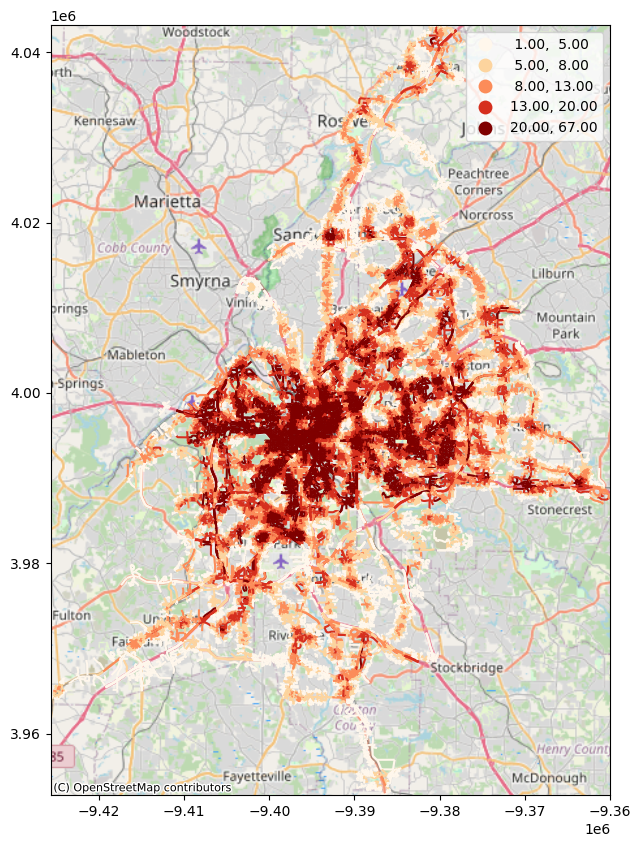

In [61]:
transit_stops_plot = transit_stops_final[transit_stops_final['number_of_bus_stops'] > 0]
transit_stops_plot = transit_stops_plot.to_crs(epsg=3857)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

transit_stops_plot.plot(column='number_of_bus_stops',
                        cmap='OrRd',
                        scheme='quantiles',
                        legend=True,
                        ax=ax)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_xlim(transit_stops_plot.total_bounds[[0, 2]])
ax.set_ylim(transit_stops_plot.total_bounds[[1, 3]])

plt.show()

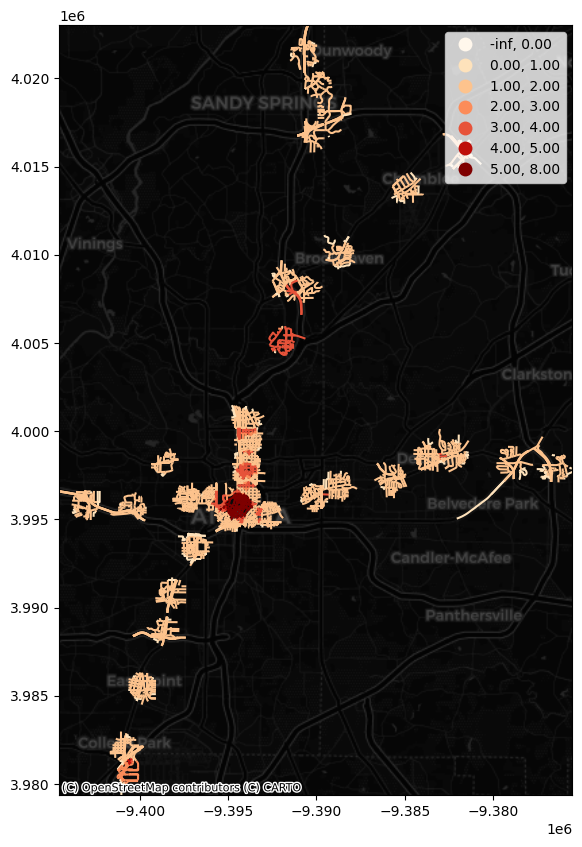

In [69]:
transit_stops_plot = transit_stops_final[transit_stops_final['number_of_subway_stops'] > 0]
transit_stops_plot = transit_stops_plot.to_crs(epsg=3857)

bin_edges = [0, 1, 2, 3, 4, 5]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

transit_stops_plot.plot(column='number_of_subway_stops',
                        cmap='OrRd',
                        scheme='user_defined',
                        classification_kwds={'bins': bin_edges},
                        legend=True,
                        ax=ax)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatter)

ax.set_xlim(transit_stops_plot.total_bounds[[0, 2]])
ax.set_ylim(transit_stops_plot.total_bounds[[1, 3]])

plt.show()